# Bilag 6 - Model Evaluering
Vi skal have en måde, at evaluere vores model på, dette gøres på to måder.
- Antal punkter ikke detekteret
- Fejl på detekterede punkter

BEMÆRK: Trænings/validerings splittet, samt annoteringerne SKAL være de samme som modellen er trænet på.

Først importeres nødvendige biblioteker.

In [97]:
import os
import cv2
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Og imports lavet til dette projekt.

In [98]:
PROGRAM_PATH = os.path.abspath("..")
if PROGRAM_PATH not in sys.path:
    sys.path.append(PROGRAM_PATH)

In [99]:
from Helpers.GeneralHelpers import *
from Helpers.RHDHelpers import *
from DataHandling.PreProcessing import *
from Model.PoolingAndFire import create_loss_function
from ModelConfig import *

En reference til modellen.

In [100]:
MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_test2.h5py")

Vi bliver nødt til at angive anker størrelsen her.

In [101]:
ANCHOR_WIDTH = 20
ANCHOR_HEIGHT = 20

Vi ønske at vise et par eksemple, hvor mange?

In [102]:
SAMPELS_TO_SHOW = 3

På grund af den måde keras håndtere brugerdefinerede tabs funktioner, bliver vi nødt til at have en reference til denne her.

In [103]:
l = create_loss_function(ANCHOR_WIDTH, ANCHOR_HEIGHT,
                         LABEL_WEIGHT,
                         OFFSET_LOSS_WEIGHT,
                         NUM_CLASSES,
                         EPSILON,
                         BATCHSIZE)

Modellen kan så indlæses.

In [104]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

Alle validerings sampels indlæses så.

In [105]:
samples = np.array(get_all_samples(VALIDATION_DIR, sample_type='png'))

Data kan nu læses ind.

In [106]:
labels, images = load_data_with_anchors(samples,
                                        VALIDATION_DIR,
                                        VALIDATION_ANNOTATIONS,
                                        WIDTH, HEIGHT,
                                        ANCHOR_WIDTH, ANCHOR_HEIGHT,
                                        int(WIDTH/ANCHOR_WIDTH)/2,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

Der laves en kopi, der kan bruges til at vise resultater på, uden at ændrer de oprindelige billeder.

In [107]:
images_show = np.zeros((len(images), WIDTH, HEIGHT, 3), dtype=np.uint8)

for c, s in enumerate(samples):
    images_show[c] = load_image(VALIDATION_DIR, s)

Billederne fodres nu til modellen, og der skrives lidt information ud om processrings tid.

In [108]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    res[c] = model.predict(im.reshape(1, WIDTH, HEIGHT, CHANNELS))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.029341991086607996
Max processing time: 1.0957353115081787
Min processing time: 0.02494072914123535
Average processing time excepting first: 0.026747360136677167


Vi laver en funktion, til at udtrække punkterne fra resultat matricer.

In [109]:
def get_points(res_mat, num_classes, is_label, threshold):
    result_points = np.zeros((num_classes, 2))
    for i in range(num_classes):
        finger_index = i
        if finger_index >= num_classes/2:
            finger_index -= num_classes/2
        
        single_point_prediction = np.zeros((ANCHOR_WIDTH, ANCHOR_HEIGHT, 3))
        single_point_prediction[:, :, 0] = res_mat[:, :, i]
        single_point_prediction[:, :, 1] = res_mat[:, :, num_classes+i*2]
        single_point_prediction[:, :, 2] = res_mat[:, :, num_classes+1+i*2]
        
        anchors = get_anchors(WIDTH, HEIGHT, ANCHOR_WIDTH, ANCHOR_HEIGHT)

        label_points = get_all_points_from_prediction(single_point_prediction,
                                                      anchors,
                                                      threshold=threshold,
                                                      offset_weight=int(WIDTH/ANCHOR_WIDTH)/2,
                                                      is_label=is_label)
        
        x_points = np.zeros(len(label_points))
        y_points = np.zeros(len(label_points))
        for counter, p in enumerate(label_points):
            x_points[counter] = p[0] + p[2]
            y_points[counter] = p[1] + p[2]
        
        x = -1
        y = -1
        if len(label_points) > 0:
            x = np.mean(x_points)
            y = np.mean(y_points)
        
        result_points[i] = (x, y)
    return result_points

Denne bruges nu, til at hente alle punkter fra labels

In [110]:
label_points = []
for c, l in enumerate(labels):
    points = get_points(labels[c], NUM_CLASSES, True, 1.0)
    label_points.append(points)

Og derefter alle punkter fra modellens resultat.

In [111]:
prediction_points = []
for c, r in enumerate(res):
    points = get_points(res[c], NUM_CLASSES, False, THRESHOLD)
    prediction_points.append(points)

Der udvælges nogle tilfældige samples der vises

In [112]:
sample_show = np.random.randint(0, len(samples), size=SAMPELS_TO_SHOW)

Punkterne fra labels tegnes derpå med grøn

In [113]:
for s in sample_show:
    for p in label_points[s]:
        if p[0] >= 0 and p[1] >= 0:
            cv2.circle(images_show[s], (int(p[0]), int(p[1])), 1, (0, 255, 0), thickness=2)

Og forudsigelserne fra modellen med blå

In [114]:
for s in sample_show:
    for p in prediction_points[s]:
        if p[0] >= 0 and p[1] >= 0:
            cv2.circle(images_show[s], (int(p[0]), int(p[1])), 1, (0, 0, 255), thickness=2)

Dette kan så vises

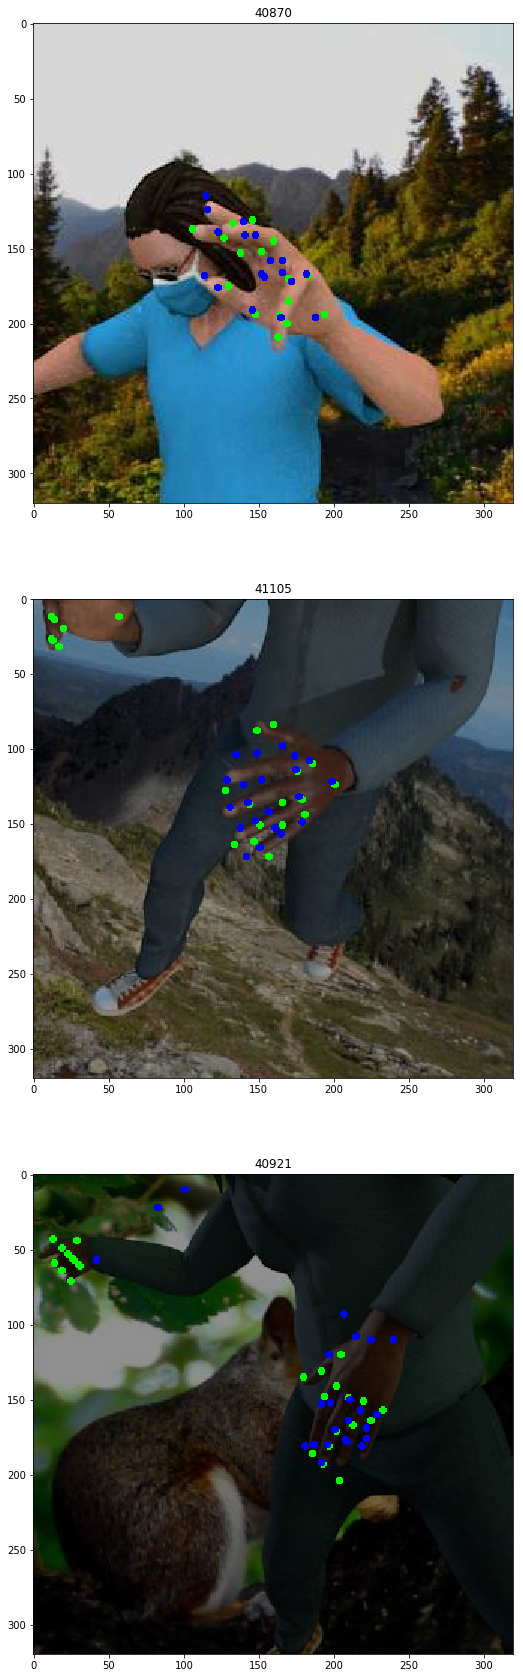

In [115]:
f, subs = plt.subplots(len(sample_show), 1, figsize=(15, 10*len(sample_show)))
for c, s in enumerate(sample_show):
    subs[c].imshow(images_show[s])
    subs[c].set_title(f"{samples[s]}")

Vi er nu interesseret i, hvor tit modellen har ret.<br>
For det første, når der er et punkt, hvor tit forudsiger modellen så at det punkt er der(true positive), dette skal helst være så højt som muligt. For det andet, hvor tit forudsiger modellen et punkt, der ikke er der(false positive), dette tal skal helst være så lavt som muligt.

In [116]:
num_points = 0
num_predicted_true = 0
num_predicted_false = 0
for li in range(len(samples)):
    for pi, p_label in enumerate(label_points[li]):
        p_prediction = prediction_points[li][pi]
        
        if p_label[0] >= 0 and p_label[1] >= 0:
            num_points += 1
        
            if p_prediction[0] >= 0 and p_prediction[1] >= 0:
                num_predicted_true += 1
        else:
            if p_prediction[0] >= 0 and p_prediction[1] >= 0:
                num_predicted_false += 1

print(f"Number of points: {num_points}")
print(f"Number of true positives: {num_predicted_true}  -  {num_predicted_true/num_points*100}%")
print(f"Number of false positives: {num_predicted_false}  -  {num_predicted_false/num_points*100}%")

Number of points: 10224
Number of true positives: 6653  -  65.07237871674492%
Number of false positives: 3732  -  36.502347417840376%


Det sidste vi så kigger på er, hvor nøjagtige de punkter der blev detekteret korrekt er. Specifikt kigger vi på den afstand der er mellem det egentlige punkt, og det forudsagte. Dette skal helst være så lavt som muligt.

In [117]:
max_dist = None
min_dist = None
all_dist = []
for li in range(len(samples)):
    for pi, p_label in enumerate(label_points[li]):
        p_prediction = prediction_points[li][pi]
        
        if p_label[0] >= 0 and p_label[1] >= 0:
            if p_prediction[0] >= 0 and p_prediction[1] >= 0:
                d = np.linalg.norm(p_label - p_prediction)
                all_dist.append(d)
                
                if max_dist is None:
                    max_dist = d
                elif d > max_dist:
                    max_dist = d
                
                if min_dist is None:
                    min_dist = d
                elif d < min_dist:
                    min_dist = d
                    
all_dist = np.array(all_dist)
avg_error_dist = np.mean(all_dist)
                    
print(f"Maximum error distance: {max_dist}")
print(f"Minimum error distance: {min_dist}")
print(f"Average error distance: {avg_error_dist}")

Maximum error distance: 241.77699730714662
Minimum error distance: 0.003700830474044583
Average error distance: 18.74996606351452
